>[Human Activities Recognition with Smart Phone (Tensorflow)](#scrollTo=2I3wx4Xjw8lZ)

>>[Import Libraries and dataset](#scrollTo=luKZZT--2p_1)

>>[Preprocessing](#scrollTo=agAIVRrK1YjO)

>>[KMeans cluster](#scrollTo=QMjiaaSO-V_d)

>>>[Randomly assign initial clusters](#scrollTo=CYzOoVM1X7JT)

>>>[Assgin each sample to its nearest centroid](#scrollTo=uoJtruHnYTYZ)

>>>[Get new centroids by averaging out the assignment.](#scrollTo=n7_PSZNPYjrm)

>>>[Run the K-means algorithm](#scrollTo=TRTkYNh1XSeg)

>>[Neural Network Model](#scrollTo=iMMU9e4Tfcrd)

>>>[Network Object](#scrollTo=g3vx29ZNuWTN)

>>>[Data Object](#scrollTo=TidZ8CX1ub6T)

>>>[Training object](#scrollTo=OJq26PR9ueu9)



# Human Activities Recognition with Smart Phone (Tensorflow) 

This notebook is created for the tensorflow skill test of [SharpestMinds](https://www.sharpestminds.com/)

Here is my [LinkedIn](https://www.linkedin.com/in/botao-deng-9a632a104/), and I'm open to connection. Feel free to connect, and if you have any question or suggestion with regard to this notebook. Please send me messge or comment below. Thanks.

## Import Libraries and dataset

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

In [21]:
train = pd.read_csv("../input/train.csv") # (7352, 563)
test = pd.read_csv("../input/test.csv") # (2947, 563)

In [22]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


## Preprocessing

Random shuffle the dataset, because the raw dataset have the data from same subject & activities grouped together. 

In [23]:
train = train.sample(frac=1)
test = test.sample(frac=1)

Drop the last two columns:'subject' and 'Activity', the 'Activity' is our target label

In [24]:
Y_train = train.Activity
train = train.drop(['Activity','subject'], axis=1) #(7352, 561)

Y_test = test.Activity
test = test.drop(['Activity','subject'], axis=1) #(2947, 561)

## KMeans cluster

This section of code follows the structure from this [tutorial](http://learningtensorflow.com/lesson6/) with modification. 

### Randomly assign initial clusters

In [25]:
def generate_initial_centroid(samples, num_cluster):
  '''
  This is the first step of K-means. 
  samples: tensor (num_samples, num_features)
  num_cluster: K, number of clusters.
  
  '''
  num_samples = tf.shape(samples)[0]
  random_indices = tf.random_shuffle(tf.range(0, num_samples))
  centroid_indices = tf.slice(random_indices, [0], [num_cluster])
  init_centroid = tf.gather(samples, centroid_indices)
  
  return init_centroid
  

*Test the initial cluster generating function*

In [26]:
init_test = train.iloc[:1500].values

init_placeholder = tf.placeholder(tf.float32, [1500, 561])
init_res = generate_initial_centroid(init_placeholder, 6)
with tf.Session() as sess:
  init_centroid = sess.run(init_res, feed_dict={init_placeholder:init_test})
  
print("The expected shape is (6, 561) and the generated shape is {0}".format(init_centroid.shape))

The expected shape is (6, 561) and the generated shape is (6, 561)


### Assgin each sample to its nearest centroid

In [27]:
# Check broadcasting rules. 

a = np.array([[[1,2,3],[4,5,6]]]) # (1,2,3) -- (1, num_samples, num_features)
b = np.array([[[1,1,1]],[[4,4,4]]]) # (2,1,3) -- (num_centroids, 1, num_features)
print("The result of a - b is \n{0}".format(a - b))
print("The shape of a - b is {0}".format((a-b).shape))

The result of a - b is 
[[[ 0  1  2]
  [ 3  4  5]]

 [[-3 -2 -1]
  [ 0  1  2]]]
The shape of a - b is (2, 2, 3)


In [28]:
def assign_to_nearest(samples, centroids):
  """
  This function assign each sample to its nearest centroid. 
  samples: tensor, (num_samples, num_features)
  centroids: tensor, (num_centroids, num_features)
  """
  expend_samples = tf.expand_dims(samples, 0) # samples become (1, num_samples, num_features)
  expend_centroid = tf.expand_dims(centroids, 1) # centroid become (num_centroid, 1, num_features)
  
  ## each entry represents how far a sample to a centroid. 
  distances = tf.reduce_sum(tf.square(tf.subtract(expend_samples, expend_centroid)), 2) # distance: (num_centroid, num_samples)
  
  ## which centorid each sample is assigned to. 
  nearest_index = tf.argmin(distances, 0) # nearest_index:(num_samples)
  
  return nearest_index

In [31]:
assign_samples = tf.constant(np.array([[1,2,3],[4,5,6]]))
assign_centroid = tf.constant(np.array([[1,1,1],[4,4,4]]))
with tf.Session() as sess:
  assign_nearest_index = assign_to_nearest(assign_samples, assign_centroid)
  assign_res = sess.run(assign_nearest_index)

print("The expected output is (0,1), and the actual output is {0}".format(assign_res))
print("The first sample (1,2,3) should be assigned to centroid (1,1,1)")
print("The second sample (4,5,5) should be assigned to centroid (4,4,4)")

The expected output is (0,1), and the actual output is [0 1]
The first sample (1,2,3) should be assigned to centroid (1,1,1)
The second sample (4,5,5) should be assigned to centroid (4,4,4)


### Get new centroids by averaging out the assignment.

In [32]:
def update_centroid(samples, nearest_index, num_clusters):
  """
  samples: tensor, (num_samples, num_features)
  nearest_index: tensor, (num_samples)
  num_clusters: int
  """
  
  nearest_index = tf.to_int32(nearest_index)
  partitions = tf.dynamic_partition(samples, nearest_index, num_clusters)
  new_centroids = tf.concat([tf.reduce_mean(partition, 0, keep_dims=True) for partition in partitions], axis=0)
  
  return new_centroids, nearest_index

*Test the update function*

In [33]:
# Test the function: update_centroid.
with tf.Session() as sess:
  new_cent, _ = update_centroid(assign_samples, assign_res, 2)
  update_res = sess.run(new_cent)
  
print("The expected new centroids are (1,2,3), (4,5,6)")
print("The actual new centroids are \n{0}".format(update_res))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
The expected new centroids are (1,2,3), (4,5,6)
The actual new centroids are 
[[1 2 3]
 [4 5 6]]


### Get new centroids by averaging out the assignment.

In [34]:
def update_centroid(samples, nearest_index, num_clusters):
  """
  samples: tensor, (num_samples, num_features)
  nearest_index: tensor, (num_samples)
  num_clusters: int
  """
  
  nearest_index = tf.to_int32(nearest_index)
  partitions = tf.dynamic_partition(samples, nearest_index, num_clusters)
  new_centroids = tf.concat([tf.reduce_mean(partition, 0, keep_dims=True) for partition in partitions], axis=0)
  
  return new_centroids, nearest_index

### Run the K-means algorithm

In [35]:
k_means_placeholder = tf.placeholder(tf.float32, shape=(7352, 561))
updated_centroids = tf.placeholder(tf.float32, shape=(6, 561))

init_centroids = generate_initial_centroid(k_means_placeholder, num_cluster=6)


nearest_index = assign_to_nearest(k_means_placeholder,updated_centroids)
updated_centroid = update_centroid(k_means_placeholder, nearest_index, 6)

with tf.Session() as sess:
  centroids = sess.run(init_centroids, feed_dict={k_means_placeholder:train})
  for i in range(0, 300):
    
    centroids,nearest_index = sess.run(updated_centroid, feed_dict={k_means_placeholder:train,
                                                         updated_centroids:centroids})
    

In [36]:
pd.crosstab(nearest_index, Y_train)

Activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
row_0,,,,,,
0,4,390,625,0,0,0
1,0,0,0,377,728,159
2,294,51,3,0,0,0
3,5,1,0,849,258,914
4,0,796,746,0,0,0
5,1104,48,0,0,0,0


Take out message:

1) We can see that basically walking activities are separated out from the passive activities. Cluster 0 and Cluster 3 are filled with walking activities, while the rest clusters represent the passive activities. 

2) Cluster 0 has more 'walking' and 'walking upstairs' in it, while majority of samples of cluster 3 are 'walking downstairs'. That means 'walking downstairs' are easier to separate out from the other two, while the 'walking' and 'walking upstair' are very easy to get mixed.

3) Cluster 2 and 5 are filled with 'laying', and cluster 1 and 4 are filled with sitting and standing. Laying is clearly easier to distinguished from the other two. And it seems that k-means algorithm has difficulites identifying sitting and standing. 

## Neural Network Model

One-hot encoded our target label

In [37]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

train = train.as_matrix()
test = test.as_matrix()

Y_train = Y_train.as_matrix()
Y_test = Y_test.as_matrix()

In [38]:
FEATURE_DIM = 561
LEARNING_RATE = 0.001
LABEL_DIM = 6
BATCH_SIZE = 64
NUM_EPOCH = 100

### Network Object

In [39]:
class Neural_Network():
  
  def __init__(self, feature_dim = FEATURE_DIM, label_dim = LABEL_DIM):
    self.feature_dim = feature_dim
    self.label_dim = label_dim
    
    
  def build_network(self, learning_rate=LEARNING_RATE):
    
    self.train_X = tf.placeholder(tf.float32, [None, self.feature_dim])
    self.train_Y = tf.placeholder(tf.float32, [None, self.label_dim])
    
    self.layer_1 = self.dense_layer(self.train_X, self.feature_dim, 
                                    1024, activation=tf.nn.relu, name='layer_1')
    self.layer_2 = self.dense_layer(self.layer_1, 1024, 512, 
                                   activation=tf.nn.relu, name='layer_2')
    self.layer_3 = self.dense_layer(self.layer_2, 512, 64, 
                                   activation=tf.nn.relu, name='layer_3')
    self.output = self.dense_layer(self.layer_3, 64, 6, name='output')
    
    self.loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=self.output, labels = self.train_Y))
    
    self.optimizer = tf.train.AdamOptimizer(learning_rate)
    
    self.train_step = self.optimizer.minimize(self.loss)
    
    self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.output,1), 
                                                    tf.argmax(self.train_Y, 1)),'float'))
    
  def dense_layer(self, inputs, input_size, output_size, name, activation=None):
    
    W = tf.get_variable(name=name+'_w',shape=(input_size, output_size), 
                        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable(name=name+'_b', shape=(output_size))
    out = tf.matmul(inputs, W) + b
    
    if activation:
      return activation(out)
    else:
      return out
    

### Data Object

In [40]:
class Data():
  
  def __init__(self, train_X, train_Y, batch_size=BATCH_SIZE):
    
    self.train_X = train_X
    self.train_Y = train_Y
    self.batch_size = batch_size
    self.num_batch = self.train_X.shape[0]//batch_size
    
  def generate_batch(self):
    
    for i in range(self.num_batch):
      
      x = self.train_X[(i*self.batch_size):(i+1)*self.batch_size, :]
      y = self.train_Y[(i*self.batch_size):(i+1)*self.batch_size]
      
      yield x, y 
    

### Training Object

In [41]:
class Learn():
  
  def __init__(self, train_X, train_Y, test_X, test_Y, 
               batch_size=BATCH_SIZE, epoch = NUM_EPOCH):
    
    self.batch_size = batch_size
    self.epoch = epoch
    
    self.network = Neural_Network()
    self.network.build_network(learning_rate=0.001)
    self.data = Data(train_X, train_Y, self.batch_size)
    self.test_X = test_X
    self.test_Y = test_Y
  
  def run_training(self):
    init = tf.initialize_all_variables()
    
    with tf.Session() as sess:
      
      sess.run(init)
      
      training_loss = []
      counter, tmp_loss = 0, 0
      
      for i in range(self.epoch):
        
        for x, y in self.data.generate_batch():
          
          feed_dict = {self.network.train_X:x, self.network.train_Y:y}
        
          _, loss = sess.run([self.network.train_step, self.network.loss], 
                             feed_dict=feed_dict)
          
          if counter % 100 == 0 and counter!=0:
            training_loss.append(tmp_loss/100)
            tmp_loss = 0
          else:
            tmp_loss += loss
            
          counter += 1
          
        print("Epoch {0}, loss is {1}".format(i, loss))
        
        
        
      self.training_loss = training_loss
      acc = sess.run([self.network.accuracy], feed_dict={self.network.train_X:self.test_X,
                                                        self.network.train_Y:self.test_Y})
      print("The testing accuracy is {0}".format(acc))
      
  def plot_training_loss(self):
    plt.plot(self.training_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, loss is 0.09496860951185226
Epoch 1, loss is 0.06639573723077774
Epoch 2, loss is 0.05449884757399559
Epoch 3, loss is 0.0431816428899765
Epoch 4, loss is 0.033515721559524536
Epoch 5, loss is 0.06847625970840454
Epoch 6, loss is 0.04517471045255661
Epoch 7, loss is 0.030373353511095047
Epoch 8, loss is 0.02954712323844433
Epoch 9, loss is 0.04194289445877075
Epoch 10, loss is 0.032571204006671906
Epoch 11, loss is 0.0992649644613266
Epoch 12, loss is 0.053786974400281906
Epoch 13, loss is 0.04780363291501999
Epoch 14, loss is 0.05192997679114342
Epoch 15, loss is 0.06462991237640381
Epoch 16, loss is 0.06070361286401749
Epoch 17, loss is 0.06555362045764923
Epoch 18, loss is 0.07087200880050659
Epoch 19, loss is 0.133

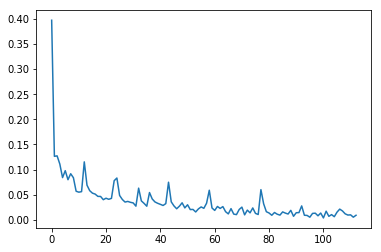

In [42]:
tf.reset_default_graph()

learner = Learn(train, Y_train, test, Y_test, epoch=NUM_EPOCH)
learner.run_training()
learner.plot_training_loss()